In [2]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [2]:
pip install gurobipy


[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
#a handful of sites
sites = ['Barcelona','Belgrade','Berlin','Brussels','Bucharest','Budapest','Copenhagen','Dublin','Hamburg','Istanbul','Kiev','London','Madrid','Milan','Moscow','Munich','Paris','Prague','Rome','Saint Petersburg','Sofia','Stockholm','Vienna','Warsaw']
# sites = ['Barcelona','Belgrade','Berlin','Brussels','Bucharest','Budapest','Copenhagen']
latlng = ['latitude', 'longitude']
position = pd.read_csv('./data/position.csv', index_col="City")
flighttime = pd.read_csv('./data/flight_time.csv', index_col="City")
distance = pd.read_csv('./data/distance.csv', index_col="City")
position.head(5)
# print(len(sites))

,latitude,longitude
City,,
Barcelona,41.3888,2.1590
Belgrade,44.8040,20.4651
Berlin,52.5244,13.4105
Brussels,50.8505,4.3488
Bucharest,44.4323,26.1063


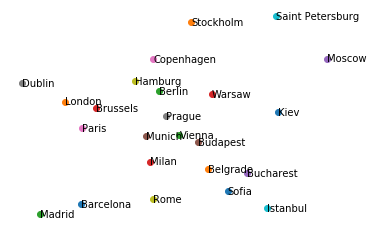

In [5]:
#make some positions (so we can plot this)
positions = dict( ( city, (position.loc[city, 'longitude'], position.loc[city, 'latitude']) ) for city in sites)
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.gca().axis('off');

In [6]:
# get distanc between cities
distances = dict( ((s1,s2), distance.loc[s1, s2] ) for s1 in positions for s2 in positions if s1!=s2)

In [7]:
K = 4 #the number of sales people 
#create the problme
prob=LpProblem("vehicle", LpMinimize)

In [8]:
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

In [9]:
#constraints
for k in sites:
    cap = 1 if k != 'Berlin' else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==cap
    #outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==cap
    
#subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 'Berlin' and j!= 'Berlin') and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

In [10]:
%time prob.solve()
#prob.solve(solver=GLPK_CMD(options=['--simplex']))

Wall time: 1h 4min 4s


1

In [11]:
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges
tours = get_next_site('Berlin')
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !='Berlin':
        t.append(get_next_site(t[-1][1])[-1])

In [12]:
for t in tours:
    print(' -> '.join([ a for a,b in t]+['Berlin']))

Berlin -> Brussels -> Paris -> London -> Dublin -> Hamburg -> Berlin
Berlin -> Copenhagen -> Stockholm -> Saint Petersburg -> Moscow -> Kiev -> Warsaw -> Berlin
Berlin -> Prague -> Rome -> Barcelona -> Madrid -> Milan -> Munich -> Berlin
Berlin -> Vienna -> Belgrade -> Sofia -> Istanbul -> Bucharest -> Budapest -> Berlin


In [13]:
totalTime = 0;
for t in tours:
    time = 0
    for i in range(0, len(t)):
        time += flighttime.loc[t[i][0], t[i][1]]
#         print(flighttime.loc[t[i][0], t[i][1]])
#     print(time)
    if time > totalTime:
        totalTime = time
print(totalTime)

1988


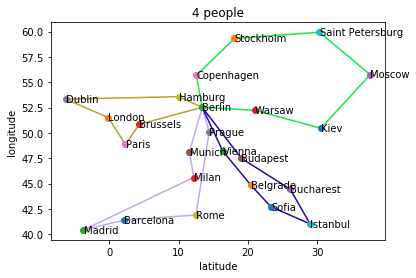

In [28]:
#draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

#draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.title('%d '%K + 'people' if K > 1 else 'person')
plt.xlabel('latitude')
plt.ylabel('longitude')
# plt.gca().axis('off')
plt.show()

In [1]:
print('Longest time spent:', totalTime, '(min)')
print('Total distance:', value(prob.objective), '(km)')

NameError: name 'totalTime' is not defined

In [30]:
plt.savefig('my_plot.png')

<Figure size 432x288 with 0 Axes>